# Impor libraries

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import gzip
import shutil
import glob

# Load data

In [2]:
#Annual Resident Population Estimates for Metropolitan/Micropolitan Statistical Areas (https://www.census.gov/data/tables/time-series/demo/popest/2020s-total-metro-and-micro-statistical-areas.html first dataset)

popData = pd.read_csv("data/cbsa-est2022.csv", encoding="latin-1")
popData = popData[['CBSA', 'NAME', 'LSAD', 'POPESTIMATE2020', 'POPESTIMATE2021', 'POPESTIMATE2022']]
popData

,CBSA,NAME,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022
0,10180,"Abilene, TX",Metropolitan Statistical Area,176866,177829,179308
1,10180,"Callahan County, TX",County or equivalent,13744,14078,14210
2,10180,"Jones County, TX",County or equivalent,19678,19809,19935
3,10180,"Taylor County, TX",County or equivalent,143444,143942,145163
4,10420,"Akron, OH",Metropolitan Statistical Area,701625,696225,697627
...,...,...,...,...,...,...
2794,49460,"Yankton County, SD",County or equivalent,23282,23334,23373
2795,49780,"Zanesville, OH",Micropolitan Statistical Area,86450,86574,86113
2796,49780,"Muskingum County, OH",County or equivalent,86450,86574,86113
2797,49820,"Zapata, TX",Micropolitan Statistical Area,13874,13893,13849


In [9]:
#Load Core Based Statistical Areas (https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-metropolitan-statistical-area-micropolitan-statist)
#CRS 3857: https://epsg.io/3857

CBSAs = geopandas.read_file("data/tl_2019_us_cbsa.zip").to_crs(3857)
CBSAs = CBSAs[['CBSAFP', 'NAME', 'geometry']]
CBSAs['CBSAFP'] = CBSAs['CBSAFP'].astype(int)
CBSAs

,CBSAFP,NAME,geometry
0,12020,"Athens-Clarke County, GA","POLYGON ((-9299339.399 4024225.385, -9298722.4..."
1,12060,"Atlanta-Sandy Springs-Alpharetta, GA","POLYGON ((-9499808.416 3982318.514, -9499830.0..."
2,12100,"Atlantic City-Hammonton, NJ","POLYGON ((-8333014.948 4782122.394, -8333009.7..."
3,12120,"Atmore, AL","POLYGON ((-9753303.463 3638074.432, -9753303.2..."
4,12140,"Auburn, IN","POLYGON ((-9483635.192 5068556.085, -9483636.4..."
...,...,...,...
933,49060,"Winfield, KS","POLYGON ((-10814782.844 4481524.994, -10814783..."
934,49080,"Winnemucca, NV","POLYGON ((-13233024.775 5006594.818, -13233215..."
935,49100,"Winona, MN","POLYGON ((-10250133.062 5468589.383, -10250142..."
936,49180,"Winston-Salem, NC","POLYGON ((-8955841.577 4336663.225, -8955841.5..."


In [10]:
#Load states shapefile (for plotting) (https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html under States)

statesShp = geopandas.read_file("data/cb_2018_us_state_500k.zip").to_crs(3857)
statesShp = statesShp[['GEOID', 'STUSPS', 'NAME', 'geometry']]

def plotUS():
    ax = statesShp.plot(figsize=(20, 10))
    ax.axis('equal')
    plt.xlim(-1.5e7, -0.7e7)
    plt.ylim(2.5e6, 7e6)
    return ax

In [11]:
#Download LODES data for orgin-destination travel (how many people commute from place X to place Y)

states = ['al', 'ak', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la',
          'me', 'md', 'ma', 'mi', 'mn', 'mo', 'ms', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny', 'nc', 'nd', 'oh', 'ok',
          'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy']

base_url = "https://lehd.ces.census.gov/data/lodes/LODES8/"

folder_name = "data/LODES"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

for state in states:
    if state == 'ak':
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2016.csv.gz"
        file_name = state + "_od_main_JT00_2016.csv.gz"
    elif state == 'ar':
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2019.csv.gz"
        file_name = state + "_od_main_JT00_2019.csv.gz"
    elif state == 'ms':
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2018.csv.gz"
        file_name = state + "_od_main_JT00_2018.csv.gz"
    else:
        file_url = base_url + state + "/od/" + state + "_od_main_JT00_2020.csv.gz"
        file_name = state + "_od_main_JT00_2020.csv.gz"
    
    file_path = os.path.join(folder_name, file_name)
    file_path_csv = file_path[:-3]
    if os.path.exists(file_path_csv):
        print("File aleady exists", file_path_csv)
        continue #Do not re-download
    
    print("Downloading", file_name)
    response = requests.get(file_url)
    
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print("Download complete.")
    
    # Unzip the file
    unzipped_file_name = file_name[:-3]  # Remove '.gz' extension
    with gzip.open(file_path, 'rb') as f_in:
        with open(os.path.join(folder_name, unzipped_file_name), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    print("Unzipped", unzipped_file_name)
    os.remove(file_path)
    print("Deleted", file_name)

File aleady exists data/LODES/al_od_main_JT00_2020.csv
File aleady exists data/LODES/ak_od_main_JT00_2016.csv
File aleady exists data/LODES/ar_od_main_JT00_2019.csv
File aleady exists data/LODES/az_od_main_JT00_2020.csv
File aleady exists data/LODES/ca_od_main_JT00_2020.csv
File aleady exists data/LODES/co_od_main_JT00_2020.csv
File aleady exists data/LODES/ct_od_main_JT00_2020.csv
File aleady exists data/LODES/de_od_main_JT00_2020.csv
File aleady exists data/LODES/fl_od_main_JT00_2020.csv
File aleady exists data/LODES/ga_od_main_JT00_2020.csv
File aleady exists data/LODES/hi_od_main_JT00_2020.csv
File aleady exists data/LODES/id_od_main_JT00_2020.csv
File aleady exists data/LODES/il_od_main_JT00_2020.csv
File aleady exists data/LODES/in_od_main_JT00_2020.csv
File aleady exists data/LODES/ia_od_main_JT00_2020.csv
File aleady exists data/LODES/ks_od_main_JT00_2020.csv
File aleady exists data/LODES/ky_od_main_JT00_2020.csv
File aleady exists data/LODES/la_od_main_JT00_2020.csv
File alead

In [12]:
#Download crosswalk data (which CBSAs contain which blocks/block groups)

base_url = "https://lehd.ces.census.gov/data/lodes/LODES8/"
folder_name = "data/LODES_XWALK"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
for state in states:
    
    file_url = base_url + state + "/" + state + "_xwalk.csv.gz"
    file_name = state + "_xwalk.csv.gz"
    
    
    file_path = os.path.join(folder_name, file_name)
    file_path_csv = file_path[:-3]
    if os.path.exists(file_path_csv):
        print("File aleady exists", file_path_csv)
        continue #Do not re-download
    
    print("Downloading", file_name)
    response = requests.get(file_url)
    
    with open(file_path, 'wb') as file:
        file.write(response.content)
    
    print("Download complete.")
    
    unzipped_file_name = file_name[:-3]
    with gzip.open(file_path, 'rb') as f_in:
        with open(os.path.join(folder_name, unzipped_file_name), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    print("Unzipped", unzipped_file_name)
    
    os.remove(file_path)
    
    print("Deleted", file_name)

File aleady exists data/LODES_XWALK/al_xwalk.csv
File aleady exists data/LODES_XWALK/ak_xwalk.csv
File aleady exists data/LODES_XWALK/ar_xwalk.csv
File aleady exists data/LODES_XWALK/az_xwalk.csv
File aleady exists data/LODES_XWALK/ca_xwalk.csv
File aleady exists data/LODES_XWALK/co_xwalk.csv
File aleady exists data/LODES_XWALK/ct_xwalk.csv
File aleady exists data/LODES_XWALK/de_xwalk.csv
File aleady exists data/LODES_XWALK/fl_xwalk.csv
File aleady exists data/LODES_XWALK/ga_xwalk.csv
File aleady exists data/LODES_XWALK/hi_xwalk.csv
File aleady exists data/LODES_XWALK/id_xwalk.csv
File aleady exists data/LODES_XWALK/il_xwalk.csv
File aleady exists data/LODES_XWALK/in_xwalk.csv
File aleady exists data/LODES_XWALK/ia_xwalk.csv
File aleady exists data/LODES_XWALK/ks_xwalk.csv
File aleady exists data/LODES_XWALK/ky_xwalk.csv
File aleady exists data/LODES_XWALK/la_xwalk.csv
File aleady exists data/LODES_XWALK/me_xwalk.csv
File aleady exists data/LODES_XWALK/md_xwalk.csv
File aleady exists d

In [13]:
#Load orgin-destination data (for TX)
stateData = []

for path in glob.glob("data/LODES/*_od_main_JT00_20*.csv"):
    print(".", end="")
    odData = pd.read_csv(path)
    odData = odData[['w_geocode', 'h_geocode', 'S000']]
    stateData.append(odData)

odData = pd.concat(stateData)
odData
#.................................................

..................................................

,w_geocode,h_geocode,S000
0,10010201001001,10010208013004,1
1,10010201001001,10670304002042,1
2,10010201001012,10010201002008,1
3,10010201001012,10010203001003,1
4,10010201001012,10010203001011,1
...,...,...,...
199091,560459513003044,560459513003062,1
199092,560459513003045,560459511002403,1
199093,560459513003050,560459513002016,1
199094,560459513003050,560459513002053,1


In [14]:
#Load crosswalk data (for TX)

stateData = []

for path in glob.glob("data/LODES_XWALK/*_xwalk.csv"):
    print(".", end="")
    xwalk = pd.read_csv(path, low_memory=False)
    xwalk = xwalk[['ctyname', 'bgrp', 'cbsa']]
    stateData.append(xwalk)

xwalk = pd.concat(stateData)
xwalk
#.................................................

..................................................

,ctyname,bgrp,cbsa
0,"Autauga County, AL",10010211002,33860
1,"Tallapoosa County, AL",11239623012,10760
2,"Washington County, AL",11290442004,33660
3,"Winston County, AL",11339656023,99999
4,"Shelby County, AL",11170301021,13820
...,...,...,...
53764,"Sweetwater County, WY",560379716002,40540
53765,"Lincoln County, WY",560239782002,99999
53766,"Sweetwater County, WY",560379705001,40540
53767,"Sweetwater County, WY",560379705001,40540


# Analysis

## Create OD count lookup table
How many people commuted from blockgroup x to blockgroup y = odTable[x, y]

In [15]:
#Extract block group code
odData['h_bgrp'] = (odData['h_geocode'] / 10**3).astype(int)
odData['w_bgrp'] = (odData['w_geocode'] / 10**3).astype(int)

In [16]:
#Lookup table to make finding a blockgroup's cbsa fast
bgrpToCbsa = xwalk.groupby('bgrp').first()['cbsa']
bgrpToCbsa = dict(zip(bgrpToCbsa.index, bgrpToCbsa.values)) #Dict is faster for lookup

In [17]:
#Lookup cbsa for blockgroup
odData['w_cbsa'] = odData['w_bgrp'].apply(lambda c: bgrpToCbsa[c])
odData['h_cbsa'] = odData['h_bgrp'].apply(lambda c: bgrpToCbsa[c])

In [27]:
odTable = odData.groupby(['h_cbsa', 'w_cbsa']).sum()['S000']
odTable

h_cbsa  w_cbsa
10100   10100       15856.0
        15100         346.0
        26700         235.0
        33580         286.0
        38180         214.0
                    ...    
99999   49700        1361.0
        49740         135.0
        49780        1396.0
        49820          45.0
        99999     3408087.0
Name: S000, Length: 29102, dtype: float64

## Working population lookup table
How many people work in blockgroup x (and commute somewhere) = workingPop[x]

In [28]:
workingPop = odData.groupby(['h_cbsa']).sum()['S000']
workingPop

h_cbsa
10100      19624.0
10140      28706.0
10180      66780.0
10220      15247.0
10300      32522.0
           ...    
49700      68007.0
49740      63974.0
49780      33194.0
49820       4216.0
99999    6268416.0
Name: S000, Length: 910, dtype: float64

## Main gdf table with data for every CBSA

In [18]:
gdf = pd.merge(popData, CBSAs, on="NAME", how="inner")
gdf = geopandas.GeoDataFrame(gdf)
gdf

,CBSA,NAME,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,CBSAFP,geometry
0,10180,"Abilene, TX",Metropolitan Statistical Area,176866,177829,179308,10180,"POLYGON ((-11148262.500 3832132.455, -11148249..."
1,10420,"Akron, OH",Metropolitan Statistical Area,701625,696225,697627,10420,"POLYGON ((-9060481.928 5063847.837, -9060475.5..."
2,10500,"Albany, GA",Metropolitan Statistical Area,148244,144922,145786,10500,"POLYGON ((-9400975.184 3713776.408, -9400980.6..."
3,10540,"Albany-Lebanon, OR",Metropolitan Statistical Area,128978,129948,130467,10540,"POLYGON ((-13720236.776 5551262.937, -13720393..."
4,10580,"Albany-Schenectady-Troy, NY",Metropolitan Statistical Area,899748,905369,904617,10580,"POLYGON ((-8247992.807 5305256.748, -8248085.6..."
...,...,...,...,...,...,...,...,...
923,49300,"Wooster, OH",Micropolitan Statistical Area,116906,116129,116559,49300,"POLYGON ((-9089178.853 5010653.858, -9088979.1..."
924,49380,"Worthington, MN",Micropolitan Statistical Area,22207,22047,21947,49380,"POLYGON ((-10627927.538 5441934.306, -10627791..."
925,49460,"Yankton, SD",Micropolitan Statistical Area,23282,23334,23373,49460,"POLYGON ((-10855702.126 5337734.746, -10853435..."
926,49780,"Zanesville, OH",Micropolitan Statistical Area,86450,86574,86113,49780,"POLYGON ((-9149881.580 4868949.855, -9149879.9..."


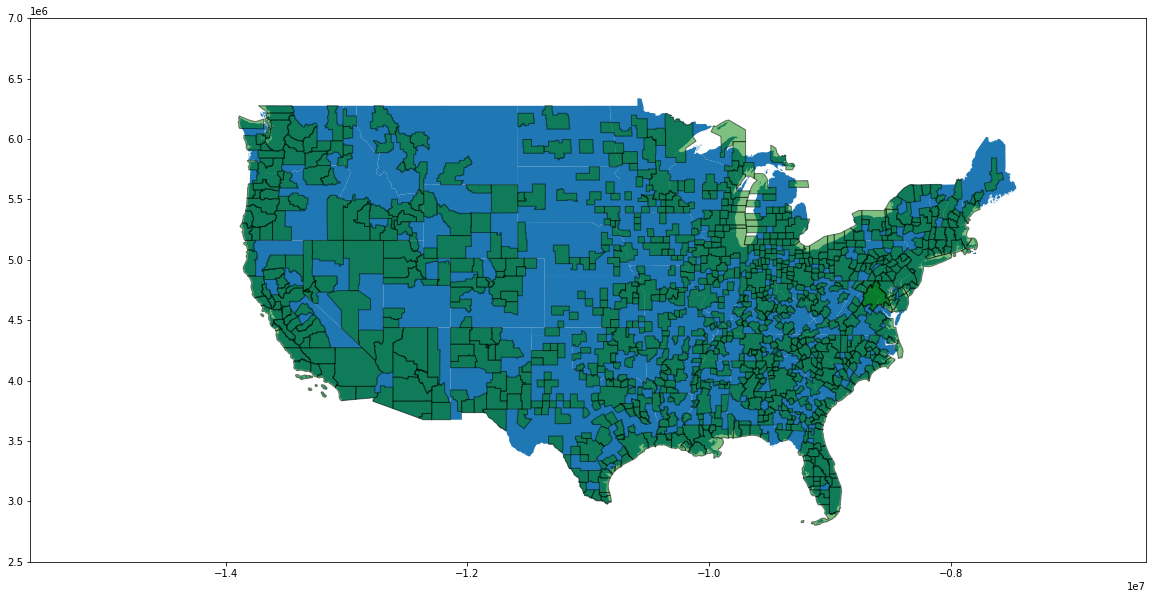

In [19]:
ax = plotUS()
gdf.plot(ax=ax, color="green", edgecolor="black", linewidth=1, alpha=0.5);

## Find large metro areas and small metro/micro areas

In [20]:
#Urban centers are Metropolitan Statistical Areas with population > 1,000,000
#Potential liminal places are Metropolitan/Micropolitan Statistical Areas with population < 100,000

gdf['metro'] = (gdf['POPESTIMATE2021'] > 1_000_000) & (gdf['LSAD'] == 'Metropolitan Statistical Area')
gdf['micro'] = (gdf['POPESTIMATE2021'] < 100_000) & ((gdf['LSAD'] == 'Metropolitan Statistical Area') | (gdf['LSAD'] == 'Micropolitan Statistical Area'))

print(gdf['metro'].sum(), "large metro areas")
print(gdf['micro'].sum(), "small metro/micro areas")

56 large metro areas
536 small metro/micro areas


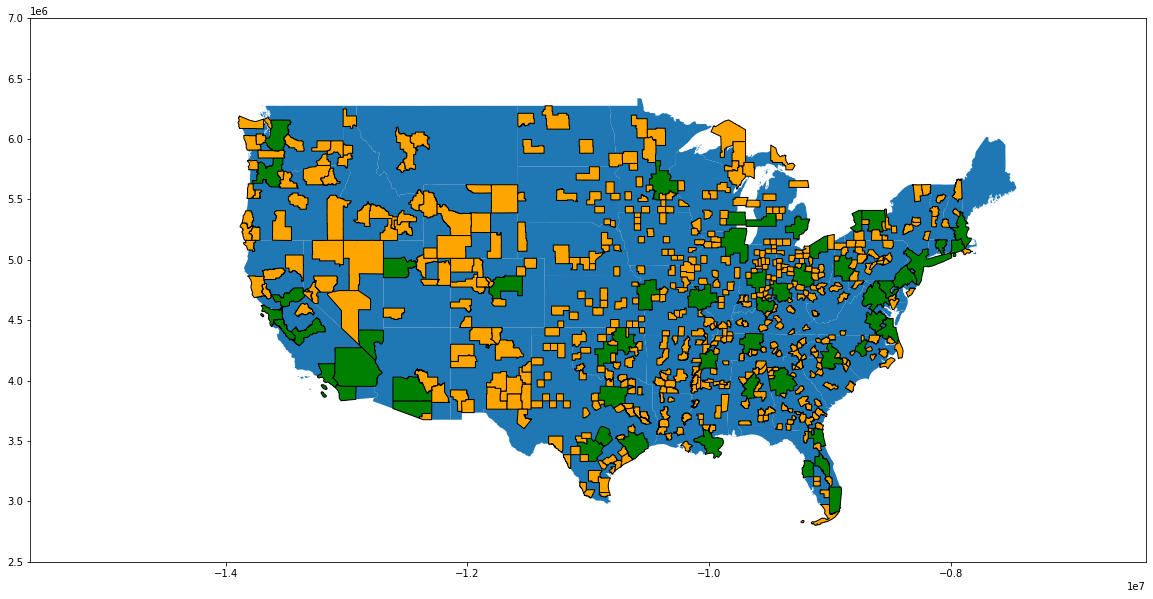

In [21]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1)
gdf[gdf['micro']].plot(ax=ax, color="orange", edgecolor="black", linewidth=1);

## 100Mi buffer around large metro areas

In [22]:
buffRad = 100 * 1609.34 #100Mi to m
gdf['buff'] = gdf.buffer(buffRad)

In [23]:
# For each area, check if it intersects any metro area

def inBuff(geom):
    # Does geom intersect any metro area?
    # if geom is None:
    #     return False
    for metroArea in gdf[gdf['metro']]['buff']:
        if metroArea.intersects(geom):
            return True
    return False

gdf['inBuff'] = gdf['geometry'].apply(inBuff)

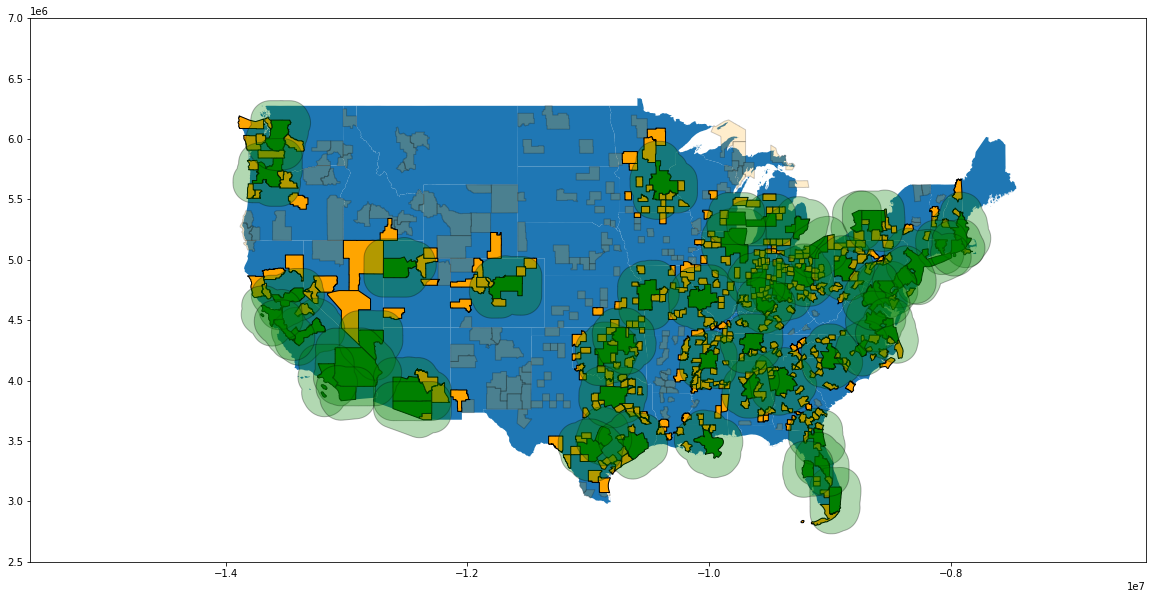

In [24]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1)
gdf[gdf['micro']].plot(ax=ax, color="orange", edgecolor="black", linewidth=1, alpha=0.2)
gdf[gdf['micro'] & gdf['inBuff']].plot(ax=ax, color="orange", edgecolor="black", linewidth=1)
gdf[gdf['metro']]['buff'].plot(ax=ax, color="green", edgecolor="black", linewidth=1, alpha=0.3);

In [25]:
#Possible liminal places
gdf[gdf['micro'] & gdf['inBuff']][['NAME', 'POPESTIMATE2021']]

,NAME,POPESTIMATE2021
40,"Bloomsburg-Berwick, PA",83083
55,"Cape Girardeau, MO-IL",97757
57,"Carson City, NV",58796
81,"Columbus, IN",82730
84,"Corvallis, OR",96277
...,...,...
917,"Wilson, NC",78283
918,"Winfield, KS",34652
920,"Winona, MN",49750
922,"Woodward, OK",23947


## How many people commute to a nearby large metro area?

In [29]:
def countCommuteBuff(row):
    count = 0
    microId = row['CBSAFP']
    for _, metro in gdf[gdf['metro']].iterrows():
        if metro['buff'].intersects(row['geometry']):
            metroId = metro['CBSAFP']
            try:
                count += odTable[microId, metroId]
            except KeyError:
                pass
    return count

gdf['commuteBuffCount'] = gdf.apply(countCommuteBuff, axis=1)
gdf['workingPop'] = gdf['CBSAFP'].apply(lambda cbsa: workingPop.get(cbsa, float('nan')))
gdf['commutePercent'] = gdf['commuteBuffCount'] / gdf['workingPop'] * 100
gdf

,CBSA,NAME,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,CBSAFP,geometry,metro,micro,buff,inBuff,commuteBuffCount,workingPop,commutePercent
0,10180,"Abilene, TX",Metropolitan Statistical Area,176866,177829,179308,10180,"POLYGON ((-11148262.500 3832132.455, -11148249...",False,False,"POLYGON ((-11309677.340 3783320.344, -11309649...",True,7146.0,66780.0,10.700809
1,10420,"Akron, OH",Metropolitan Statistical Area,701625,696225,697627,10420,"POLYGON ((-9060481.928 5063847.837, -9060475.5...",False,False,"POLYGON ((-9254365.317 5020257.954, -9254364.7...",True,86722.0,306288.0,28.313875
2,10500,"Albany, GA",Metropolitan Statistical Area,148244,144922,145786,10500,"POLYGON ((-9400975.184 3713776.408, -9400980.6...",False,False,"POLYGON ((-9578772.815 3741602.731, -9578761.8...",True,3686.0,50430.0,7.309141
3,10540,"Albany-Lebanon, OR",Metropolitan Statistical Area,128978,129948,130467,10540,"POLYGON ((-13720236.776 5551262.937, -13720393...",False,False,"POLYGON ((-13880404.968 5518947.795, -13880524...",True,6390.0,54728.0,11.675925
4,10580,"Albany-Schenectady-Troy, NY",Metropolitan Statistical Area,899748,905369,904617,10580,"POLYGON ((-8247992.807 5305256.748, -8248085.6...",False,False,"POLYGON ((-8472736.168 5278351.957, -8472566.1...",True,25289.0,390058.0,6.483395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,49300,"Wooster, OH",Micropolitan Statistical Area,116906,116129,116559,49300,"POLYGON ((-9089178.853 5010653.858, -9088979.1...",False,False,"POLYGON ((-9303427.427 5003041.204, -9303435.5...",True,8380.0,48312.0,17.345587
924,49380,"Worthington, MN",Micropolitan Statistical Area,22207,22047,21947,49380,"POLYGON ((-10627927.538 5441934.306, -10627791...",False,True,"POLYGON ((-10853572.863 5404615.190, -10853573...",False,0.0,9763.0,0.000000
925,49460,"Yankton, SD",Micropolitan Statistical Area,23282,23334,23373,49460,"POLYGON ((-10855702.126 5337734.746, -10853435...",False,True,"POLYGON ((-11029881.460 5334892.015, -11029883...",False,0.0,10222.0,0.000000
926,49780,"Zanesville, OH",Micropolitan Statistical Area,86450,86574,86113,49780,"POLYGON ((-9149881.580 4868949.855, -9149879.9...",False,True,"POLYGON ((-9314594.513 4866712.033, -9313763.6...",True,10044.0,33194.0,30.258480


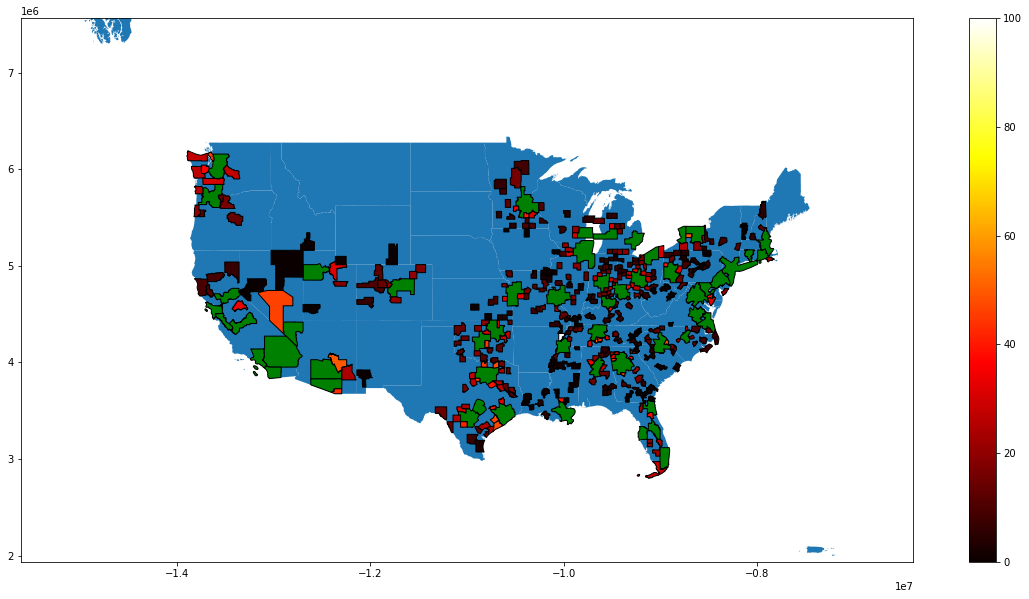

In [30]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1)
gdf[gdf['micro'] & gdf['inBuff']].plot(column='commutePercent', ax=ax, edgecolor="black", linewidth=1, legend=True, cmap="hot");
plt.savefig("figures/commute_percent.png")

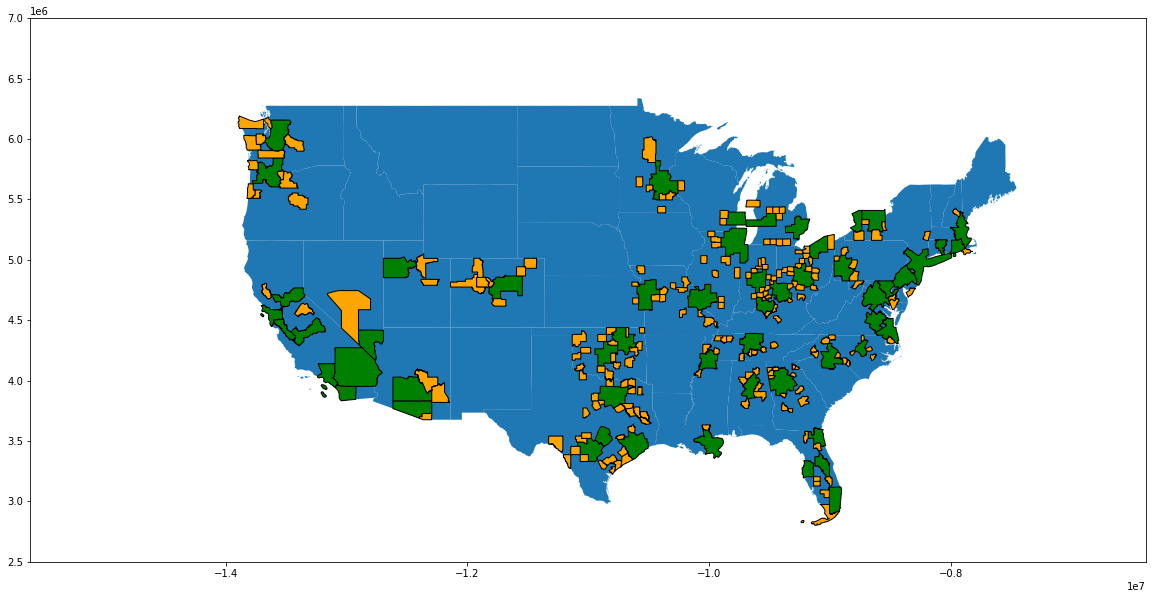

In [31]:
ax = plotUS()
gdf[gdf['metro']].plot(ax=ax, color="green", edgecolor="black", linewidth=1)
gdf[gdf['micro'] & gdf['inBuff'] & (gdf['commutePercent'] > 10)].plot(ax=ax, color="orange", edgecolor="black", linewidth=1);

In [36]:
len(gdf[gdf['micro'] & gdf['inBuff'] & (gdf['commutePercent'] > 15)])

148